# Acoular Sandbox
*Notes taken by Nicholas Butterly when learning and experimenting with python module 'acoular'.* <br>
[Acoular website](http://acoular.org/)

In [1]:
# Install module package
!python3 -m pip install acoular

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# import relevant modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
import acoular

%matplotlib inline

### Acoular Missing Submodules
*Exploring submodule import error*

In [3]:
import pydoc

!python3 -m pydoc -k traitsview
!python3 -m pydoc -k nidaqimport

acoular.traitsviews - Implements support separate traits_view definitions for all relevant
Unreleased!
acoular.nidaqimport - nidaqimport.py: interface to nidaq mx
Unreleased!


In [4]:
# help(acoular)
# acoular submodules listed in help(acoular)
acoular_submodules_from_help = [
    "calib",
    "configuration",
    "environments", 
    "fastFuncs",
    "fbeamform",
    "fileimport",
    "grids",
    "h5cache",
    "h5files",
    "internal",
    "microphones",
#    "nidaqimport", listed as submodule in help(acoular), but can't be called? Not listed in acoular.__dict__
    "signals",
    "sources",
    "spectra",
    "tbeamform",
    "tprocess",
#     "traitsviews", listed as submodule in help(acoular), but can't be called? Not listed in acoular.__dict__
    "trajectory",
    "version"]

In [5]:
# import submodules stored in acoular.__dict__
import types
acoular_submods = [keys for keys,values in acoular.__dict__.items() if type(values) == types.ModuleType]
print(acoular_submods)

['version', 'os', 'configuration', 'h5files', 'h5cache', 'fileimport', 'internal', 'calib', 'trajectory', 'microphones', 'environments', 'signals', 'sources', 'grids', 'tprocess', 'fastFuncs', 'spectra', 'fbeamform', 'tbeamform']


In [6]:
# check to see if all acoular submodules listed in __dict__ are in help(acoular)
print([acoular_submods[i] in acoular_submodules_from_help for i in range(len(acoular_submods))])

# check to see if all acoular submodules listed in help(acoular) are in __dict__
print([acoular_submodules_from_help[i] in acoular_submods for i in range(len(acoular_submodules_from_help))])

# submodule acoular.os exists but is not listed in help(acoular). Likely the same as module 'os'

[True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


___
**Findings**:
 - 19 submodules working, stored in list \`acoular_submods\`
 - Submodules 'nidaqimport' and 'traitsviews' listed in help(acoular) but cannot be imported in linux or Windows environment
  - Submodules not listed on organisation [website](http://acoular.org/py-modindex.html)
 - Likely cause - feature removed by creators

### Reading help(acoular.\<submodule\>)

In [7]:
help("acoular." + acoular_submods[2])

Help on module acoular.configuration in acoular:

NAME
    acoular.configuration - Implements global configuration of Acoular.

DESCRIPTION
    .. autosummary::
        :toctree: generated/
    
        config

CLASSES
    traits.has_traits.HasStrictTraits(traits.has_traits.HasTraits)
        Config
    
    class Config(traits.has_traits.HasStrictTraits)
     |  This class implements the global configuration of the Acoular package.
     |  
     |  An instance of this class can be accessed for adjustment of the following 
     |  properties.
     |  General caching behaviour can be controlled by :attr:`global_caching`.
     |  The package used to read and write .h5 files can be specified 
     |  by :attr:`h5library`.    
     |  
     |  Example: 
     |      For using Acoular with h5py package and overwrite existing cache:
     |      
     |      >>>    import acoular
     |      >>>    acoular.config.h5library = "h5py"
     |      >>>    acoular.config.global_caching = "overwrite"

### Acoular Example Scripts

/home/butterlyn/.local/lib/python3.8/site-packages/acoular/__init__.py
[('Mixer_5b9466d8ebf527b3faacc42a178e54cf_cache.h5', 1)]
[('Mixer_5b9466d8ebf527b3faacc42a178e54cf_cache.h5', 1), ('void_cache.h5', 1)]
[('Mixer_5b9466d8ebf527b3faacc42a178e54cf_cache.h5', 1), ('void_cache.h5', 2)]


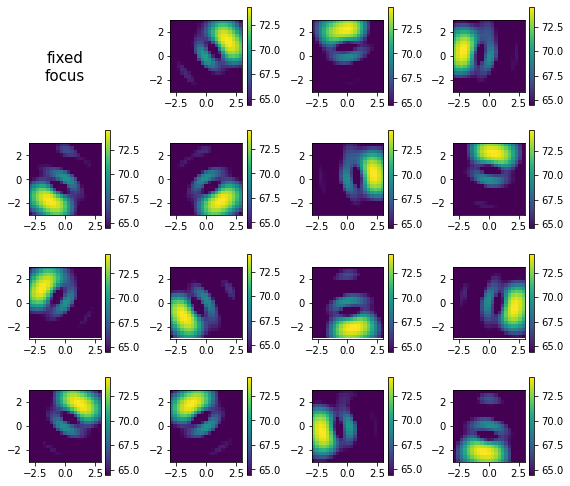

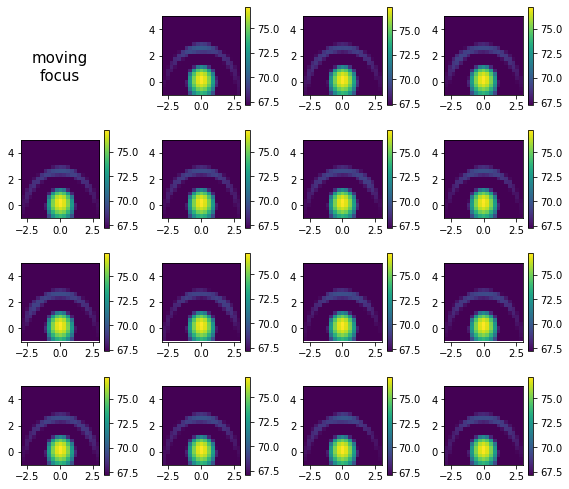

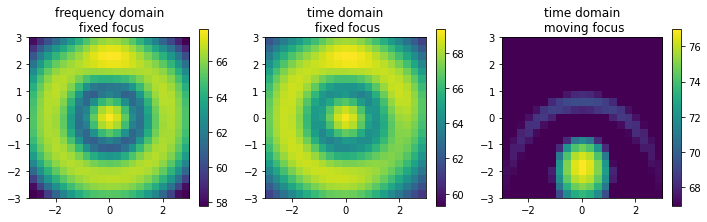

In [8]:
# Example taken from http://acoular.org/examples/example_rotating_point_source.html
# -*- coding: utf-8 -*-
"""
Example "Rotating point source" for Acoular library.

Demonstrates the use of acoular for a point source 
moving on a circle trajectory.

Uses synthesized data.

Copyright (c) 2006-2019 Acoular Development Team.
All rights reserved.
"""
from __future__ import print_function

import acoular
print(acoular.__file__)

from os import path
import sys
from numpy import empty, clip, sqrt, arange, log10, sort, array, pi, zeros, \
hypot, cos, sin, linspace, hstack, cross, dot, newaxis
from numpy.linalg import norm
from acoular import td_dir, L_p, TimeSamples, Calib, MicGeom, PowerSpectra, \
RectGrid, BeamformerBase, BeamformerEig, BeamformerOrth, BeamformerCleansc, \
MaskedTimeSamples, FiltFiltOctave, Trajectory, BeamformerTimeSq, TimeAverage, \
BeamformerTimeSqTraj, \
TimeCache, FiltOctave, BeamformerTime, TimePower, IntegratorSectorTime, \
PointSource, MovingPointSource, SineGenerator, WNoiseGenerator, Mixer, WriteWAV, \
SteeringVector

from pylab import subplot, imshow, show, colorbar, plot, transpose, figure, \
psd, axis, xlim, ylim, title, tight_layout, text

#===============================================================================
# some important definitions
#===============================================================================

freq = 6144.0*3/128.0 # frequency of interest (114 Hz)
sfreq = 6144.0/2 # sampling frequency (3072 Hz)
r = 3.0 # array radius
R = 2.5 # radius of source trajectory
Z = 4 # distance of source trajectory from 
rps = 15.0/60. # revolutions per second
U = 3.0 # total number of revolutions

#===============================================================================
# construct the trajectory for the source
#===============================================================================

tr = Trajectory()
tr1 = Trajectory()
tmax = U/rps
delta_t = 1./rps/16.0 # 16 steps per revolution
for t in arange(0, tmax*1.001, delta_t):
    i = t* rps * 2 * pi #angle
    # define points for trajectory spline
    tr.points[t] = (R*cos(i), R*sin(i), Z) # anti-clockwise rotation
    tr1.points[t] = (R*cos(i), R*sin(i), Z) # anti-clockwise rotation

#===============================================================================
# define circular microphone array
#===============================================================================

m = MicGeom()
# set 28 microphone positions
m.mpos_tot = array([(r*sin(2*pi*i+pi/4), r*cos(2*pi*i+pi/4), 0) \
    for i in linspace(0.0, 1.0, 28, False)]).T

#===============================================================================
# define the different source signals
#===============================================================================
if sys.version_info > (3,):
     long = int
nsamples = long(sfreq*tmax)
n1 = WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples)
s1 = SineGenerator(sample_freq=sfreq, numsamples=nsamples, freq=freq)
s2 = SineGenerator(sample_freq=sfreq, numsamples=nsamples, freq=freq, \
    phase=pi)

#===============================================================================
# define the moving source and one fixed source
#===============================================================================

p0 = MovingPointSource(signal=s1, mics=m, trajectory=tr1)
#t = p0 # use only moving source
p1 = PointSource(signal=n1, mics=m,  loc=(0,R,Z))
t = Mixer(source = p0, sources = [p1,]) # mix both signals
#t = p1 # use only fix source

# uncomment to save the signal to a wave file
#ww = WriteWAV(source = t)
#ww.channels = [0,14]
#ww.save()

#===============================================================================
# fixed focus frequency domain beamforming
#===============================================================================

f = PowerSpectra(time_data=t, window='Hanning', overlap='50%', block_size=128, \
    ind_low=1,ind_high=30) # CSM calculation 
g = RectGrid(x_min=-3.0, x_max=+3.0, y_min=-3.0, y_max=+3.0, z=Z, increment=0.3)

st = SteeringVector(grid=g, mics=m)
b = BeamformerBase(freq_data=f, steer=st, r_diag=True)
map1 = b.synthetic(freq,3)

#===============================================================================
# fixed focus time domain beamforming
#===============================================================================
fi = FiltFiltOctave(source=t, band=freq, fraction='Third octave')
bt = BeamformerTimeSq(source=fi, steer=st, r_diag=True)
avgt = TimeAverage(source=bt, naverage=int(sfreq*tmax/16)) # 16 single images
cacht = TimeCache(source=avgt) # cache to prevent recalculation
map2 = zeros(g.shape) # accumulator for average
# plot single frames
figure(1,(8,7))
i = 1
for res in cacht.result(1):
    res0 = res[0].reshape(g.shape)
    map2 += res0 # average
    i += 1  
    subplot(4,4,i)
    mx = L_p(res0.max())
    imshow(L_p(transpose(res0)), vmax=mx, vmin=mx-10, interpolation='nearest',\
        extent=g.extend(), origin='lower')
    colorbar()
map2 /= i

subplot(4,4,1)
text(0.4,0.25,'fixed\nfocus', fontsize=15, ha='center')
axis('off')
tight_layout()


#===============================================================================
# moving focus time domain beamforming
#===============================================================================

# new grid needed, the trajectory starts at origin and is oriented towards +x
# thus, with the circular movement assumed, the center of rotation is at (0,2.5)
g1 = RectGrid(x_min=-3.0, x_max=+3.0, y_min=-1.0, y_max=+5.0, z=0, \
    increment=0.3)# grid point of origin is at trajectory (thus z=0)
st1 = SteeringVector(grid=g1, mics=m)
# beamforming with trajectory (rvec axis perpendicular to trajectory)
bts = BeamformerTimeSqTraj(source=fi, steer=st1, trajectory=tr, \
    rvec = array((0,0,1.0)))
avgts = TimeAverage(source=bts, naverage=int(sfreq*tmax/16)) # 16 single images
cachts = TimeCache(source=avgts) # cache to prevent recalculation
map3 = zeros(g1.shape) # accumulator for average
# plot single frames
figure(2,(8,7))
i = 1
for res in cachts.result(1):
    res0 = res[0].reshape(g1.shape)
    map3 += res0 # average
    i += 1  
    subplot(4,4,i)
    mx = L_p(res0.max())
    imshow(L_p(transpose(res0)), vmax=mx, vmin=mx-10, interpolation='nearest',\
        extent=g1.extend(), origin='lower')
    colorbar()
map3 /= i

subplot(4,4,1)
text(0.4,0.25,'moving\nfocus', fontsize=15, ha='center')
axis('off')
tight_layout()

#===============================================================================
# compare all three results
#===============================================================================

figure(3,(10,3))
subplot(1,3,1)
mx = L_p(map1.max())
imshow(L_p(transpose(map1)), vmax=mx, vmin=mx-10, interpolation='nearest',\
    extent=g.extend(), origin='lower')
colorbar()
title('frequency domain\n fixed focus')
subplot(1,3,2)
mx = L_p(map2.max())
imshow(L_p(transpose(map2)), vmax=mx, vmin=mx-10, interpolation='nearest',\
    extent=g.extend(), origin='lower')
colorbar()
title('time domain\n fixed focus')
subplot(1,3,3)
mx = L_p(map3.max())
imshow(L_p(transpose(map3)), vmax=mx, vmin=mx-10, interpolation='nearest',\
    extent=g.extend(), origin='lower')
colorbar()
title('time domain\n moving focus')

tight_layout()

# only display result on screen if this script is run directly
if __name__ == '__main__': show()